In [1]:
# import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2
import math
import torch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.colorbar as colorbar

import requests
from io import BytesIO
from PIL import Image
import numpy as np
from maskrcnn_benchmark.utils import cv2_util
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20*1.5, 12*1.5

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo

In [2]:
def load(img_path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    pil_image = Image.open(img_path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_video(video_path,frame_id=[0]):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    video_clip = VideoFileClip(video_path)
    if frame_id is None:
        nframes = int(video_clip.fps * video_clip.duration)
        frame_id = range(nframes)
    images = []
    for i in frame_id:
        image = video_clip.get_frame(i/video_clip.fps)
        # convert to BGR format
        image = np.array(image)[:, :, [2, 1, 0]]
        images += [image]
    video_clip.close()
    
    return images

def imshow(img):
    plt.gca().invert_yaxis()
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# num keypoints per animal, heatmap
def calculate_peaks(numparts, heatmap_avg):
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        print("score", score)
        ##logger.ERROR(‘Not enough scores provided for number of parts’)
        # return
    # threshold_detection = params[‘thre1’]
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[part, :, :]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        #peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     #np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks_binary = (sigmoid_v(map_ori) > .2)
        #print("pb shap", np.shape(peaks_binary))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks



In [3]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'jet',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    #'text.usetex': True,
    'figure.figsize': [20, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [4]:
def overlay_keypoints(image, predictions):
        #keypoints = predictions.get_field("keypoints")
        kps = predictions#keypoints.keypoints
        scores = kps.new_ones((kps.size(0), kps.size(1)))
        kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for region in kps:
            kfun = BeeKeypoints
            image = vis_keypoints_others(
                    image,
                    region.transpose((1, 0)),
                    kp_thresh=0,
                    kfun=kfun)
                
        return image


In [5]:
import cv2
import torch
from torchvision import transforms as T

from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util

import numpy as np
import matplotlib.pyplot as plt
from maskrcnn_benchmark.structures.keypoint import PersonKeypoints, BeeKeypoints, FlyKeypoints


def vis_keypoints_others(img, kps, kp_thresh=2, alpha=0.7, kfun=PersonKeypoints):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    img = img.copy()
    dataset_keypoints = kfun.NAMES
    kp_lines = kfun.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)
    
    # Draw the keypoints.
    for l in [0]:#range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        #if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
         #   cv2.line(
          #      kp_mask, p1, p2,
           #     color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        #if kps[2, i2] > kp_thresh:
         #   cv2.circle(
          #      kp_mask, p2,
           #     radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)

def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

def get_centroid(coord):
    return [(coord[0]+coord[2])/2, (coord[1]+coord[3])/2]

def get_dist(p1, p2):
    dist = math.hypot(p2[0] - p1[0], p2[1] - p1[1])
    return dist


In [6]:
#test_file = 'bee_test.png'
#image = load(test_file)
base = "../tools/datasets/pup/images/"
#base = "../tools/datasets/bee/train/"
base_val = "../tools/datasets/pup/pup_val2.json"
#base_val = "../tools/datasets/bee/annotations/train_bee_annotations2018_nondup.json"

import json
with open(base_val) as f:
    data_an = json.load(f)
#print(data_an["annotations"][0])

test_files = []
for p in data_an['images'][:]:
    test_files.append(str(p['file_name']))

print(test_files)
print(len(test_files))
test_images = []
for file in test_files:
    test_images.append(load(base +file))



['img_000003.png', 'img_000010.png', 'img_000016.png', 'img_000020.png', 'img_000022.png', 'img_000026.png', 'img_000028.png', 'img_000058.png', 'img_000062.png', 'img_000064.png', 'img_000070.png', 'img_000072.png', 'img_000077.png', 'img_000079.png', 'img_000084.png', 'img_000089.png', 'img_000096.png', 'img_000133.png', 'img_000134.png', 'img_000135.png', 'img_000137.png', 'img_000155.png', 'img_000169.png', 'img_000173.png', 'img_000174.png', 'img_000175.png', 'img_000181.png', 'img_000184.png', 'img_000188.png', 'img_000189.png', 'img_000192.png', 'img_000198.png', 'img_000221.png', 'img_000222.png', 'img_000228.png', 'img_000231.png', 'img_000235.png', 'img_000236.png', 'img_000253.png', 'img_000262.png', 'img_000263.png', 'img_000280.png', 'img_000283.png', 'img_000284.png', 'img_000286.png', 'img_000295.png', 'img_000301.png', 'img_000303.png', 'img_000311.png', 'img_000315.png', 'img_000319.png', 'img_000330.png', 'img_000340.png', 'img_000349.png', 'img_000351.png', 'img_0003

In [7]:
s_v1 = []
s_v2 = []
s_v3 = []

c_v1 = []
c_v2 = []
c_v3 = []

u_v1 = []
u_v2 = []
u_v3 = []

In [8]:
#print((s_v1[0]))

In [9]:
saver = {"standard":[{'v1':s_v1}, {'v2':s_v2}, {'v3':s_v3}],
"combined":[{'v1':c_v1}, {'v2':c_v2}, {'v3':c_v3}],
"unlabeled":[{'v1':u_v1}, {'v2':u_v2}, {'v3':u_v3}]}


In [10]:
import pickle
#with open('all_135_test_boxes.pkl', 'wb') as f:
 #   pickle.dump(saver, f)


In [11]:
import pickle
with open('all_5_test_boxes.pkl', 'rb') as f:
    r5 = pickle.load(f)
print((r5['standard'][0]['v1'][0][10]))

BoxList(num_boxes=16, image_width=2560, image_height=1440, mode=xyxy)


In [12]:
from maskrcnn_benchmark.data.datasets.evaluation import evaluate
from maskrcnn_benchmark.data import make_data_loader
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo
import pickle


config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                     'DATATYPE', 'bee', \
                     'OUTPUT_DIR', 'training_dir/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                     'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/fcos_kps_ms_training_R_50_FPN_1x_bee/mode.pth',\
                     'DATASETS.TEST', "('bee_val_cocostyle',)",\
                     'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                    ])

ds = make_data_loader(cfg, poop=True)

When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference). For training, you must also adjust the learning rate and schedule length according to the linear scaling rule. See for example: https://github.com/facebookresearch/Detectron/blob/master/configs/getting_started/tutorial_1gpu_e2e_faster_rcnn_R-50-FPN.yaml#L14


train san check: True
im p gpu:  16
DATA Path;  ('pup_val_cocostyle',)
name?
/home/bsb2144/directpose/tools/datasets/pup/pup_val2.json
datasets/pup/images
PupKeypoints
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
len ids pre  178


In [13]:
s_5= [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

c_5 = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

u_5 = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

In [14]:
# res = evaluate(ds, rr['standard'][2]['v3'][3], 'pathhe')[0]
# ap = res.results['keypoints']['AP']
# ap_50 = res.results['keypoints']['AP50']
# ap_75 = res.results['keypoints']['AP75']
# ap2 = res.results['keypoints']['APl']
# print(ap2)

NameError: name 'rr' is not defined

In [15]:
# res = evaluate(ds, s_v1[0], 'pathhe')[0]
# ap = res.results['keypoints']['AP']
# ap_50 = res.results['keypoints']['AP50']
# ap_75 = res.results['keypoints']['AP75']
# ap2 = res.results['keypoints']['APl']
# print(ap2)
data_numbers = ['all_pup.pkl3']#,'all_25_test_boxes.pkl','all_135_test_boxes.pkl']
iters = [range(0,10),range(0,4),range(0,2)]
versions = ["v1",'v2','v3']
losses = ['standard','combined','unlabeled']
#losses = ['unlabeled']

#i=0
with open(data_numbers[0], 'rb') as f:
    rr = pickle.load(f)

for l,loss in enumerate(losses):
    dic = rr[loss]
    for i,v in enumerate(versions):
        for it in iters[l]:
            #print(loss,v,it)
            #rr[loss][i][v][it]
            res = evaluate(ds, rr[loss][i][v][it], 'pathhe')[0]
            ap = res.results['keypoints']['AP']
            ap_50 = res.results['keypoints']['APm']
            ap_75 = res.results['keypoints']['AP75']
            ap2 = res.results['keypoints']['APl']
            if loss == 'standard':
                s_5[0][i].append(ap)
                s_5[1][i].append(ap_50)
                s_5[2][i].append(ap_75)
                s_5[3][i].append(ap2)
            elif loss == 'combined':
                c_5[0][i].append(ap)
                c_5[1][i].append(ap_50)
                c_5[2][i].append(ap_75)
                c_5[3][i].append(ap2)
            elif loss == 'unlabeled':
                u_5[0][i].append(ap)
                u_5[1][i].append(ap_50)
                u_5[2][i].append(ap_75)
                u_5[3][i].append(ap2)


coco_gt <pycocotools.coco.COCO object at 0x2b173648c470>
coco_dt <pycocotools.coco.COCO object at 0x2b173735edd8>
iou_type keypoints
datatype pup
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1

DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.215
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.689
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.682
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.723
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.689
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.692
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = -1.000
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b17364

DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.178
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.199
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.618
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.610
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.647
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.623
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.618
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = -1.000
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b17364

DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = -1.000
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b17364

DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.206
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.664
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.659
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.699
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.664
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.666
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = -1.000
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b17364

DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.147
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.156
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.572
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.567
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.595
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.571
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.573
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = -1.000
Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b17364

In [16]:
print(c_5[1])

[[0.7069306930693069, 0.5811881188118811, 0.6732673267326733, 0.6643564356435644], [0.5861386138613861, 0.594059405940594, 0.5841584158415841, 0.5495049504950495], [0.595049504950495, 0.6811881188118812, 0.5524752475247525, 0.5722772277227722]]


In [17]:
print(s_5[1])

[[-1.0, -1.0, -1.0, 0.6811881188118812, 0.0, 0.0, 0.7039603960396039, 0.6841584158415842, 0.689108910891089, 0.6722772277227723], [0.0, 0.0, 0.0, 0.019801980198019802, 0.0, 0.0, 0.6178217821782178, 0.6574257425742575, 0.6207920792079208, 0.6069306930693069], [0.0, 0.0, 0.0, 0.5148514851485149, 0.0, 0.0, 0.5762376237623762, 0.5861386138613861, 0.5584158415841585, 0.5534653465346535]]


In [18]:
print(u_5[1])

[[0.7019801980198019, 0.6821782178217822], [0.5702970297029702, 0.5495049504950495], [0.5405940594059406, 0.593069306930693]]


(4, 3, 10)
(4, 3, 4)
(4, 3, 2)
10


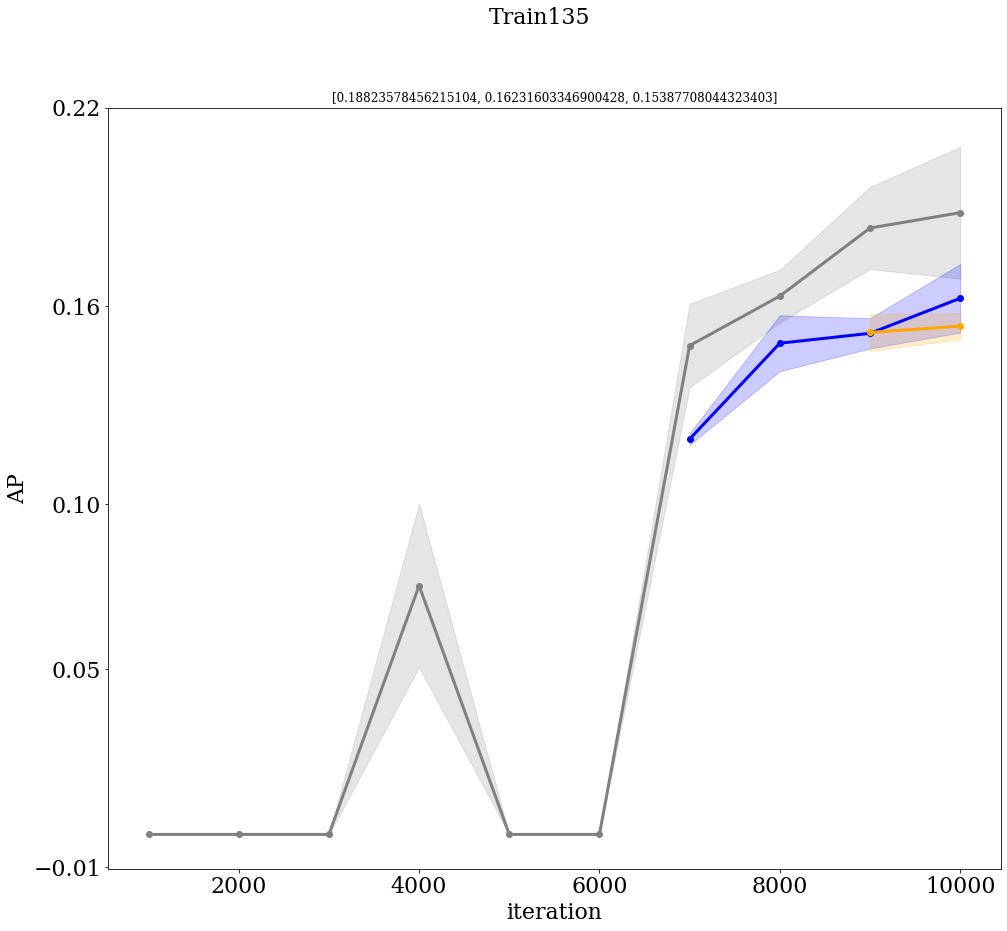

10


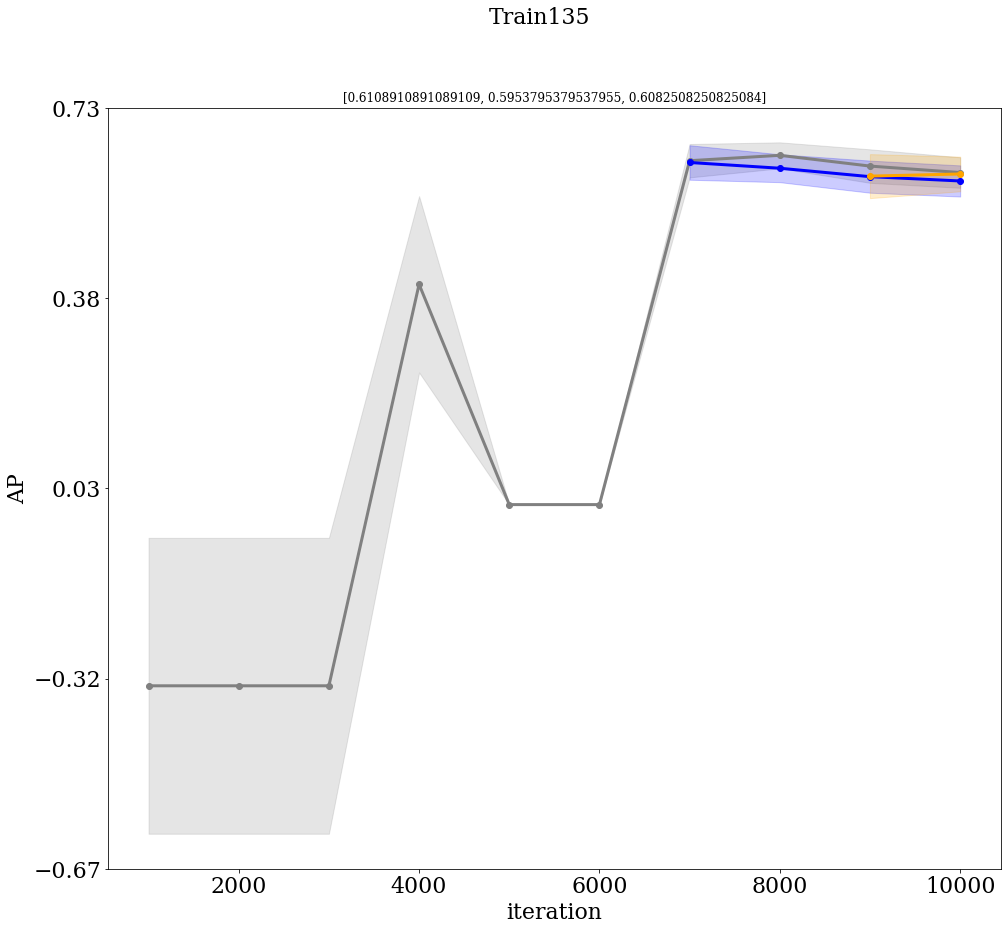

10


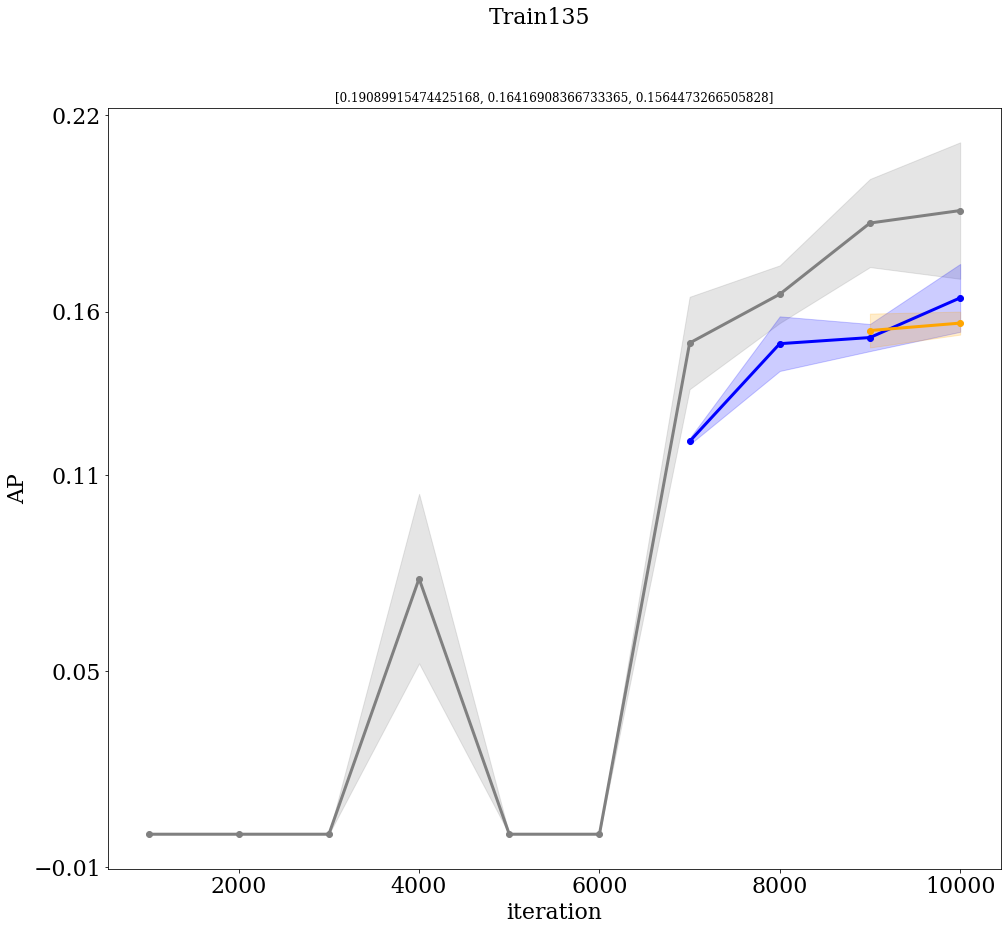

10


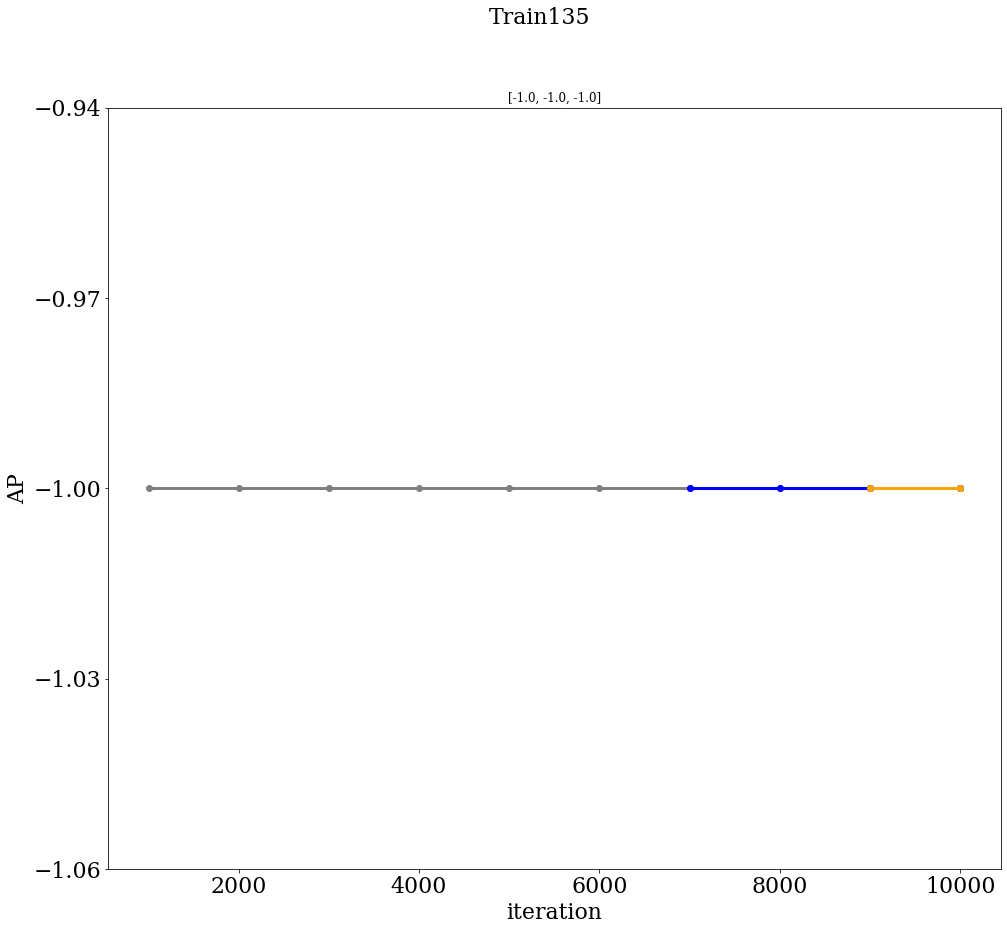

In [19]:
s_51 = np.array(s_5)
c_51 = np.array(c_5)
u_51 = np.array(u_5)
print(s_51.shape)
print(c_51.shape)
print(u_51.shape)
for gg in range(4):
    sa4 = s_51.mean(1)[gg,:]
    s_e = s_51.std(1)[gg,:]/np.sqrt(3)
    ca4 = c_51.mean(1)[gg,:]
    c_e = c_51.std(1)[gg,:]/np.sqrt(3)
    va4 = u_51.mean(1)[gg,:]
    u_e = u_51.std(1)[gg,:]/np.sqrt(3)
    it1 = np.linspace(7000,10001,len(ca4))
    itu = np.linspace(9000,10001,len(va4))
    ita = np.linspace(1000,10001,len(sa4))
    print(len(ita))
    fig, axes = plt.subplots(1,1,figsize=(16,14))
    ax = axes
    plt.xlabel('iteration', fontsize=22)
    plt.ylabel('AP', fontsize=22)
    fig.suptitle('Train135',fontsize = 22)
    colors = ['r','b','y','g']
    #plt.plot(ita, sa1, ‘-o’, c=‘grey’, label=“standard ap1")
    #plt.plot(ita, sa2, ‘-o’, c=‘grey’, label=“standard”)
    #plt.plot(ita, sa3, ‘-o’, c=‘brown’, label=“standard ap3")
    plt.plot(ita, sa4, '-o', c='grey', label='standard',linewidth=3)
    plt.fill_between(ita, np.array(sa4)-np.array(s_e), np.array(sa4)+np.array(s_e),alpha = .2,color='grey')
    #plt.plot(it1, ca1, ‘-o’, c=‘blue’, label=“combined ap1")
    #plt.plot(it1, ca2, ‘-o’, c=‘blue’, label=“combined”)
    #plt.plot(it1, ca3, ‘-o’, c=‘green’, label=“combined ap3")
    plt.plot(it1, ca4, '-o', c='blue', label='standard',linewidth=3)
    plt.fill_between(it1, np.array(ca4)-np.array(c_e), np.array(ca4)+np.array(c_e),alpha = .2,color='blue')
    #plt.plot(itu, va1, ‘-o’, c=‘orange’, label=“unlabeled ap1")
    #plt.plot(itu, va2, ‘-o’, c=‘orange’, label=“unlabeled”)
    #plt.plot(itu, va3, ‘-o’, c=‘pink’, label=“unlabeled ap3")
    plt.plot(itu, va4, '-o', c='orange', label='standard',linewidth=3)
    plt.fill_between(itu, np.array(va4)-np.array(u_e), np.array(va4)+np.array(u_e),alpha = .2,color='orange')
    # plt.plot(ita, ap2_bu*np.ones((len(ita),1)), c=‘red’, label=“Sleap bottom up”,linewidth=3)
    # plt.plot(ita, ap2_td*np.ones((len(ita),1)), c=‘green’, label=“Sleap top down”,linewidth=3)
    #ax.set_ylim(top = 35000,bottom = 5000)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    N = 5
    ymin, ymax = ax.get_ylim()
    ax.set_yticks(np.round(np.linspace(ymin, ymax, N), 2))
    xmin, xmax = ax.get_xlim()
    # ax.set_xticks(np.round(np.linspace(xmin, xmax, N), 2))
    # fig.legend(loc=‘upper left’)
    # fig.savefig(“ap_135" +‘.pdf’)
    plt.title([sa4[-1:].mean(), ca4[-1:].mean(), va4[-1:].mean()])
    plt.show()

In [ ]:
sa1 = []
for w1,w2,w3 in zip(s_5[0][0],s_5[0][1],s_5[0][2]):
    sa1.append((w1+w2+w3)/3)
ca1 = []
for w1,w2,w3 in zip(c_5[0][0],c_5[0][1],c_5[0][2]):
    ca1.append((w1+w2+w3)/3)
va1 = []
for w1,w2,w3 in zip(u_5[0][0],u_5[0][1],u_5[0][2]):
    va1.append((w1+w2+w3)/3)
    
sa2 = []
for w1,w2,w3 in zip(s_5[1][0],s_5[1][1],s_5[1][2]):
    sa2.append((w1+w2+w3)/3)
ca2 = []
for w1,w2,w3 in zip(c_5[1][0],c_5[1][1],c_5[1][2]):
    ca2.append((w1+w2+w3)/3)
va2 = []
for w1,w2,w3 in zip(u_5[1][0],u_5[1][1],u_5[1][2]):
    va2.append((w1+w2+w3)/3)
    
sa3 = []
for w1,w2,w3 in zip(s_5[2][0],s_5[2][1],s_5[2][2]):
    sa3.append((w1+w2+w3)/3)
ca3 = []
for w1,w2,w3 in zip(c_5[2][0],c_5[2][1],c_5[2][2]):
    ca3.append((w1+w2+w3)/3)
va3 = []
for w1,w2,w3 in zip(u_5[2][0],u_5[2][1],u_5[2][2]):
    va3.append((w1+w2+w3)/3)
    
sa4 = []
for w1,w2,w3 in zip(s_5[3][0],s_5[3][1],s_5[3][2]):
    sa4.append((w1+w2+w3)/3)
ca4 = []
for w1,w2,w3 in zip(c_5[3][0],c_5[3][1],c_5[3][2]):
    ca4.append((w1+w2+w3)/3)
va4 = []
for w1,w2,w3 in zip(u_5[3][0],u_5[3][1],u_5[3][2]):
    va4.append((w1+w2+w3)/3)
    
s_e = []
c_e = []
u_e = []
#print(c1)
for w1,w2,w3 in zip(s_5[1][0],s_5[1][1],s_5[1][2]):
    s_e.append(np.std([w1,w2,w3])/np.sqrt(3))
    
for w1,w2,w3 in zip(c_5[1][0],c_5[1][1],c_5[1][2]):
    c_e.append(np.std([w1,w2,w3])/np.sqrt(3))
    
for w1,w2,w3 in zip(u_5[3][0],u_5[3][1],u_5[3][2]):
    u_e.append(np.std([w1,w2,w3])/np.sqrt(3))
    
SMALL_SIZE = 11
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rcParams.update({'font.size': 22})
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=40)  # fontsize of the figure title
#plt.rc('font', 8)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
it_c = range(3000,15001,1000)
it1 = range(7000,10001,1000)
itu = range(9000,10001,1000)
ite = range(6000,14001,1000)
ita = range(1000,10001,1000)
fig, axes = plt.subplots(1,1,figsize=(16,8))
ax = axes
plt.xlabel("iteration")
plt.ylabel("MSE")
fig.suptitle("mAP: trained on 5 labeled images ",fontsize = 22)
colors = ['r','b','y','g']

#plt.plot(ita, sa1, '-o', c='grey', label="standard ap1")
#plt.plot(ita, sa2, '-o', c='grey', label="standard")
#plt.plot(ita, sa3, '-o', c='brown', label="standard ap3")
plt.plot(ita, sa4, '-o', c='grey', label="standard")
plt.fill_between(ita, np.array(sa4)-np.array(s_e), np.array(sa4)+np.array(s_e),alpha = .2,color='grey')


#plt.plot(it1, ca1, '-o', c='blue', label="combined ap1")
#plt.plot(it1, ca2, '-o', c='blue', label="combined")
#plt.plot(it1, ca3, '-o', c='green', label="combined ap3")
plt.plot(it1, ca4, '-o', c='blue', label="combined")
plt.fill_between(it1, np.array(ca4)-np.array(c_e), np.array(ca4)+np.array(c_e),alpha = .2,color='blue')


#plt.plot(itu, va1, '-o', c='orange', label="unlabeled ap1")
#plt.plot(itu, va2, '-o', c='orange', label="unlabeled")
#plt.plot(itu, va3, '-o', c='pink', label="unlabeled ap3")
plt.plot(itu, va4, '-o', c='orange', label="unlabeled")
plt.fill_between(itu, np.array(va4)-np.array(u_e), np.array(va4)+np.array(u_e),alpha = .2,color='orange')


#plt.plot(ita, bu[0:15], c='red', label="Sleap bottom up")
#plt.plot(ita, td[0:15], c='green', label="Sleap top down")
#ax.set_ylim(top = 35000,bottom = 5000)
fig.legend(loc='upper left')
fig.savefig("ap_5" +'.pdf')
plt.show()

In [ ]:
#single mse dp
import matplotlib.gridspec as gridspec
from itertools import chain
checks = [46,40 ,61,3]
data_size = "pup"
its = range(1000,10001,1000)

losses = ["p2all/standard/2", "pccccf5all/combined/2",  "p3ccall/combined/1"]
t = []
i=0
loss = losses[i]
ity = [1000, 3000,1000]
its = [ity[i]]
for p in its:
    print(p,"it")
    it = p
    if it < 1000:
        it = "0000" + str(it)
    elif it > 9999:
        it = "00" + str(it)
    else:
        it = "000" + str(it)
    config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

    cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
    cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                         'DATATYPE', 'pup', \
                         'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                         'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/fcos_kps_ms_training_R_50_FPN_1x_pup/model_'+it+'.pth',\
                         'DATASETS.TEST', "('bee_val_cocostyle',)",\
                         'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                        ])

    coco_demo = COCODemo(
                cfg,
                min_image_size=800,
                confidence_threshold=0.2,
    )


    mse_total = []
    tim = [test_images[-1]]
    for idx, image in enumerate(tim):
        mse_per_bee = []
        predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
        kps = tps.get_field("keypoints").keypoints
        bboxes = tps.bbox
        #print("BBOXES", bboxes)
        #print("KPS",kps)
        plt.gca().invert_yaxis()
        plt.imshow(predictions[:, :, [2, 1, 0]])
        plt.axis("off")
        plt.gca().invert_yaxis()

print(test_files[5])       

In [ ]:
from maskrcnn_benchmark.data.datasets.evaluation.coco import coco_eval
import tempfile
import os

# def do_coco_evaluation(
# dataset,
# predictions,
# box_only=False,
# output_folder='eva',
# iou_types='unsure',
# expected_results='dk',
# expected_results_sigma_tol='20',
datatype='bee'
# ):
predictions =  s_v1[0]#rr['standard'][0]['v1'][10]
dataset = ds
coco_results = {}
coco_results['keypoints'] = coco_eval.prepare_for_coco_keypoint(predictions, dataset)
iou_types = ["keypoints"]
results_coco = coco_eval.COCOResults(*iou_types)
print(iou_types)
iou_type = iou_types[0]
output_folder = 'pathhe'
with tempfile.NamedTemporaryFile() as f:
    file_path = f.name
    if output_folder:
        file_path = os.path.join(output_folder, iou_type + ".json")
#     res = coco_eval.evaluate_predictions_on_coco(
#         dataset.coco, coco_results[iou_type], file_path, iou_type, datatype
#     )
coco_results = coco_results[iou_type]
coco_gt = dataset.coco

# def evaluate_predictions_on_coco(
# coco_gt, coco_results, json_result_file, iou_type="bbox", datatype='person',
# ):
import json
json_result_file = file_path
with open(json_result_file, "w") as f:
    json.dump(coco_results, f)

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

coco_dt = coco_gt.loadRes(str(json_result_file)) if coco_results else COCO()

# coco_dt = coco_gt.loadRes(coco_results)
print("coco_gt",coco_gt)
print("coco_dt",coco_dt)
print("iou_type",iou_type)
print("datatype",datatype)
coco_eval = COCOeval(coco_gt, coco_dt, iou_type)#, datatype)
# coco_eval.evaluate()
# coco_eval.accumulate()
# coco_eval.summarize()

import copy
p = coco_eval.params
# add backward compatibility if useSegm is specified in params
if not p.useSegm is None:
    p.iouType = 'segm' if p.useSegm == 1 else 'bbox'
    print('useSegm (deprecated) is not None. Running {} evaluation'.format(p.iouType))
print('Evaluate annotation type *{}*'.format(p.iouType))
p.imgIds = list(np.unique(p.imgIds))
if p.useCats:
    p.catIds = list(np.unique(p.catIds))
p.maxDets = sorted(p.maxDets)
coco_eval.params=p

coco_eval._prepare()
# loop through images, area range, max detection number
catIds = p.catIds if p.useCats else [-1]

computeIoU = coco_eval.computeOks
coco_eval.ious = {(imgId, catId): computeIoU(imgId, catId) \
                for imgId in p.imgIds
                for catId in catIds}

evaluateImg = coco_eval.evaluateImg
maxDet = p.maxDets[-1]
coco_eval.evalImgs = [evaluateImg(imgId, catId, areaRng, maxDet)
         for catId in catIds
         for areaRng in p.areaRng
         for imgId in p.imgIds
     ]
coco_eval._paramsEval = copy.deepcopy(coco_eval.params)


def _toMask(anns, coco):
    # modify ann['segmentation'] by reference
    for ann in anns:
        rle = coco.annToRLE(ann)
        ann['segmentation'] = rle
p = coco_eval.params
gts=coco_eval.cocoGt.loadAnns(coco_eval.cocoGt.getAnnIds(imgIds=p.imgIds, catIds=p.catIds))
dts=coco_eval.cocoDt.loadAnns(coco_eval.cocoDt.getAnnIds(imgIds=p.imgIds, catIds=p.catIds))

imgId = p.imgIds[-1]
catId = catIds[0]
iou = computeIoU(imgId, catId)
print("imgId",imgId)
print("catid", catId)

# def computeOks(coco_eval, imgId, catId):
p = coco_eval.params
# dimention here should be Nxm
gts = coco_eval._gts[imgId, catId]
dts = coco_eval._dts[imgId, catId]
inds = np.argsort([-d['score'] for d in dts], kind='mergesort')
dts = [dts[i] for i in inds]
if len(dts) > p.maxDets[-1]:
    dts = dts[0:p.maxDets[-1]]
# if len(gts) == 0 and len(dts) == 0:
if len(gts) == 0 or len(dts) == 0:
    print('ddd')
ious = np.zeros((len(dts), len(gts)))
sigmas = p.kpt_oks_sigmas
vars = (sigmas * 2)**2
k = len(sigmas)
# compute oks between each detection and ground truth object
for j, gt in enumerate(gts):
    # create bounds for ignore regions(double the gt bbox)
    g = np.array(gt['keypoints'])
    
    xg = g[0::3]; yg = g[1::3]; vg = g[2::3]
#     print('xg:::',xg)
#     print('yg:::',yg)
#     print('vg:::',vg)
    
    k1 = np.count_nonzero(vg > 0)
    bb = gt['bbox']
    
#     print('bb:::',bb)
    
    x0 = bb[0] - bb[2]; x1 = bb[0] + bb[2] * 2
    y0 = bb[1] - bb[3]; y1 = bb[1] + bb[3] * 2
    
    plt.figure()
    plt.plot(xg,yg,'r-o')
#     plt.figure()
#     plt.plot([x0,x1],[y0,y1],'g-o')
    
    bb1 = np.reshape(bb,[-1,2])
#     print('bb1:::',bb1)
#     plt.figure()
    #plt.plot(bb1[:,0],bb1[:,1],'b-o')
    
    sss = []
    for i, dt in enumerate(dts):
        print('i:',i)
        d = np.array(dt['keypoints'])
        xd = d[0::3]; yd = d[1::3]
        
#         print('xd:::',xd)
#         print('yd:::',yd)
        
        
        
        if k1>0:
            # measure the per-keypoint distance if keypoints visible
            dx = xd - xg
            dy = yd - yg
        else:
            # measure minimum distance to keypoints in (x0,y0) & (x1,y1)
            z = np.zeros((k))
            dx = np.max((z, x0-xd),axis=0)+np.max((z, xd-x1),axis=0)
            dy = np.max((z, y0-yd),axis=0)+np.max((z, yd-y1),axis=0)
            
        e = (dx**2 + dy**2) / (1) / (gt['area']+np.spacing(1)) / 2
        
        if k1 > 0:
            e=e[vg > 0]
            
        dd = np.exp(-e)
        dd[np.isnan(dd)] = 0
        print('dd:', dd)
        
        ss = np.sum(dd) / e.shape[0]
        
        print('ss ',ss)
        plt.plot(xd,yd,'g-o')
        plt.text(xd[0], yd[0], "{:.2f}".format(round(ss, 2)), fontsize=22)
        
    
        
        ious[i, j] = ss
        sss += [ss]
    sss = np.array(sss)
#     print('sss:',sss)
    plt.title(np.max(sss[np.isfinite(sss)]))
# print(ious)